In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from preprocess_test_data import preprocess_test_data

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_rmse_score(model, X, y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    rmse = np.sqrt(mse)
    return rmse

def get_train_rmse(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    return mean_squared_error(y, pred)

import pandas as pd


df_train = pd.read_csv("data/train_clean.csv")
df_test = preprocess_test_data(pd.read_csv("data/test.csv"), df_train.columns)

Y_train = df_train['Log_SalePrice']
X_train = df_train.drop(columns=['Log_SalePrice'])

Y_test = df_test['Log_SalePrice']
X_test = df_test.drop(columns=['Log_SalePrice'])

In [5]:
ridge_model = make_pipeline(RobustScaler(), Ridge(alpha=1.2))
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

ridge_scores = get_rmse_score(ridge_model, X_train, Y_train)
print(f"Ridge RMSE: {ridge_scores.mean():.4f} (std: {ridge_scores.std():.4f})")

lasso_scores = get_rmse_score(lasso_model, X_train, Y_train)
print(f"Lasso RMSE: {lasso_scores.mean():.4f} (std: {lasso_scores.std():.4f})")

Ridge RMSE: 0.1160 (std: 0.0092)
Lasso RMSE: 0.1126 (std: 0.0081)


In [47]:
from sklearn.svm import SVR
from xgboost import XGBRegressor

svr_model = make_pipeline(
    RobustScaler(),
    SVR(C=20, epsilon=0.008, gamma=0.0003)
)

xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.01, 
    max_depth=9, 
    n_jobs=-1,
    random_state=42
)

svr_scores = get_rmse_score(svr_model, X_train, Y_train)
train_rmse = get_train_rmse(svr_model, X_train, Y_train)
print(f"SVR RMSE:     {svr_scores.mean():.4f} (std: {svr_scores.std():.4f}),    Train RMSE: {train_rmse:.4f}")

xgb_scores = get_rmse_score(xgb_model,X_train, Y_train)
train_rmse = get_train_rmse(xgb_model, X_train, Y_train)
print(f"XGBoost RMSE: {xgb_scores.mean():.4f} (std: {xgb_scores.std():.4f})     Train RMSE: {train_rmse:.4f}")

SVR RMSE:     0.1879 (std: 0.0311),    Train RMSE: 0.0061
XGBoost RMSE: 0.1423 (std: 0.0077)     Train RMSE: 0.0000


In [7]:
from sklearn.model_selection import GridSearchCV

svr_params = {
    'svr__C': [0.1, 1, 10, 20, 50],
    'svr__epsilon': [0.001, 0.01, 0.1],
    'svr__gamma': ['scale', 0.0001, 0.001, 0.01]
}

grid_svr = GridSearchCV(
    make_pipeline(RobustScaler(), SVR()), 
    svr_params, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    n_jobs=-1
)

grid_svr.fit(X_train, Y_train)

print(f"Best SVR RMSE: {-grid_svr.best_score_:.4f}")
print(f"Best Params: {grid_svr.best_params_}")

Best SVR RMSE: 0.1791
Best Params: {'svr__C': 50, 'svr__epsilon': 0.1, 'svr__gamma': 0.0001}


In [9]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10, log=True),
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = XGBRegressor(**params)
    scores = -cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error')
    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"Best XGB RMSE: {study.best_value:.4f}")
print(f"Best XGB Params: {study.best_params}")

[I 2025-12-16 16:42:17,913] A new study created in memory with name: no-name-19f02a50-5500-4196-b354-faf9d8edf193
[I 2025-12-16 16:42:21,896] Trial 0 finished with value: 0.12508802517357448 and parameters: {'n_estimators': 844, 'learning_rate': 0.005119456418860151, 'max_depth': 5, 'subsample': 0.9479581289426526, 'colsample_bytree': 0.6191699470241966, 'reg_alpha': 0.0001737334040792233, 'reg_lambda': 1.8371441758500793e-05}. Best is trial 0 with value: 0.12508802517357448.
[I 2025-12-16 16:42:39,499] Trial 1 finished with value: 0.12488083333960638 and parameters: {'n_estimators': 2669, 'learning_rate': 0.006605590969357479, 'max_depth': 10, 'subsample': 0.6235956807637619, 'colsample_bytree': 0.7063412287566209, 'reg_alpha': 0.4141547606404734, 'reg_lambda': 1.1120414283052282}. Best is trial 1 with value: 0.12488083333960638.
[I 2025-12-16 16:42:41,851] Trial 2 finished with value: 0.13060134891818884 and parameters: {'n_estimators': 573, 'learning_rate': 0.007952823994215026, 'ma

Best XGB RMSE: 0.1161
Best XGB Params: {'n_estimators': 2365, 'learning_rate': 0.014264558720150096, 'max_depth': 3, 'subsample': 0.6098236531056491, 'colsample_bytree': 0.7152613691970918, 'reg_alpha': 0.019141743300287343, 'reg_lambda': 3.0045725383852226e-05}


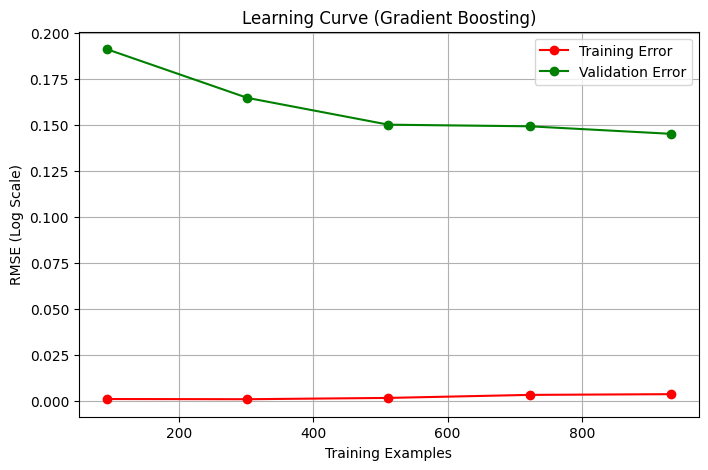

In [48]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Convert negative MSE to RMSE
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
    
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("RMSE (Log Scale)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(xgb_model, "Learning Curve (Gradient Boosting)", X_train, Y_train)

Score: 0.75
Mean Squared Error: 0.04
Index(['OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       'KitchenAbvGr', 'GarageCars', 'Log_LotArea', 'Log_GrLivArea',
       'CentralAir_Y'],
      dtype='object')


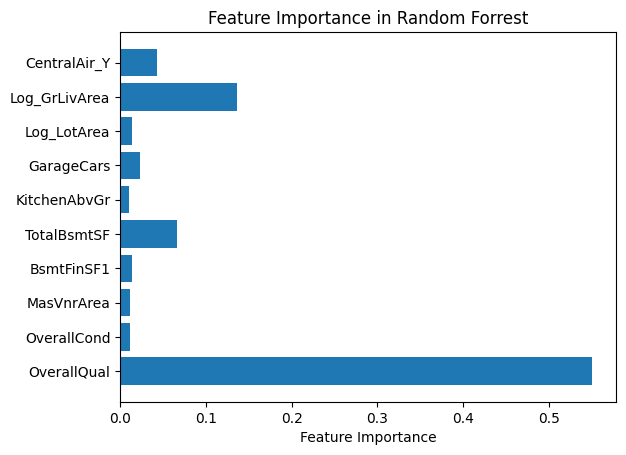

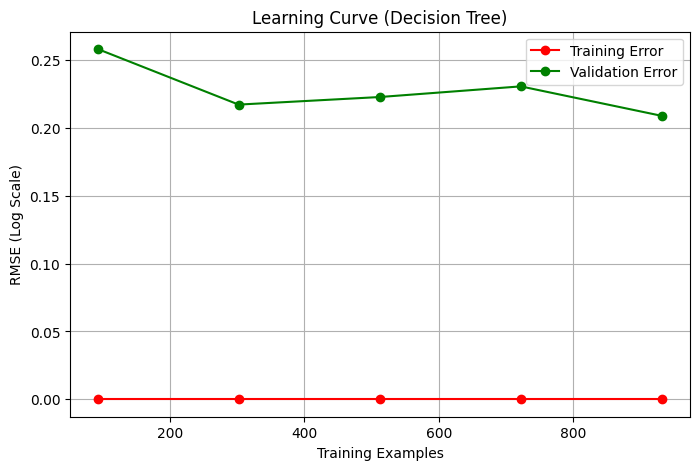

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split

seed = 42

# init decission tree classifier
clf = DecisionTreeRegressor(criterion="squared_error")

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

score = clf.score(X_test, Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(clf, "Learning Curve (Decision Tree)", X_train, Y_train)


Score: 0.88
Mean Squared Error: 0.02
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       'GarageCars', 'Log_LotArea', 'Log_GrLivArea', 'CentralAir_Y'],
      dtype='object')


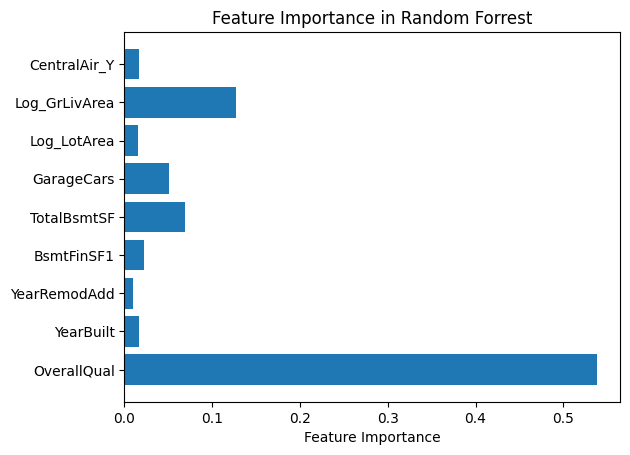

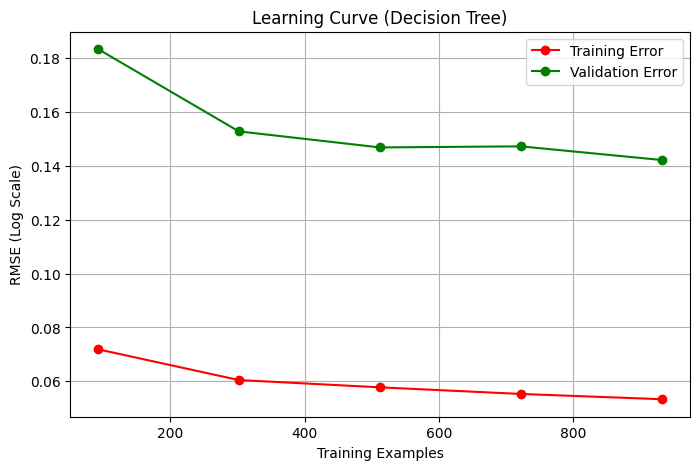

In [70]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor(n_estimators=100, random_state=seed)

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

rf_clf.fit(X_train,Y_train)
Y_pred = rf_clf.predict(X_test)

score = rf_clf.score(X_test,Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = rf_clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(rf_clf, "Learning Curve (Decision Tree)", X_train, Y_train)